# Implementing Research Paper:  Fraud Detection in Mobile Payment Systems using an XGBoost‑based Framework
https://doi.org/10.1007/s10796-022-10346-6

In [2]:
!pip install lime

In [3]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [50]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [108]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.under_sampling import RandomUnderSampler

import shap

from xgboost import XGBClassifier

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

set_config(display='text')

## Dataset Loading and Preparation

In [6]:
data = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [7]:
drop_features = ["nameOrig", "nameDest", "isFlaggedFraud"]
data.drop(columns=drop_features, inplace=True)

In [8]:
type_one_hot = pd.get_dummies(data["type"], prefix="type_")
data_without_type = data.drop(columns=["type"])
data = pd.concat([type_one_hot, data_without_type], axis=1)

In [9]:
X = data.drop(columns=["isFraud"])
y = data[["isFraud"]]

In [10]:
X.head()

,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,False,False,False,True,False,1,9839.64,170136.0,160296.36,0.0,0.0
1,False,False,False,True,False,1,1864.28,21249.0,19384.72,0.0,0.0
2,False,False,False,False,True,1,181.00,181.0,0.00,0.0,0.0
3,False,True,False,False,False,1,181.00,181.0,0.00,21182.0,0.0
4,False,False,False,True,False,1,11668.14,41554.0,29885.86,0.0,0.0


In [11]:
y.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Model Preparation

In [53]:
rus = RandomUnderSampler(sampling_strategy=0.75)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [54]:
model = XGBClassifier(booster="gbtree", eta=0.3, gamma=0, subsample=1.0, reg_lambda=1, reg_alpha=0, max_depth=6)

## Model Training

In [55]:
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
y_pred = model.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred, target_names=["Normal", "Fraud"]))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00   1588582
       Fraud       0.15      1.00      0.26      2073

    accuracy                           0.99   1590655
   macro avg       0.57      0.99      0.63   1590655
weighted avg       1.00      0.99      1.00   1590655



In [58]:
roc_auc_score(y_test, y_pred)

0.9945507244318772

## Model interpretation

### Global Surrogate Model

In [59]:
gsm_model = DecisionTreeClassifier(max_depth=4)
gsm_model.fit(X_test, y_pred)

DecisionTreeClassifier(max_depth=4)

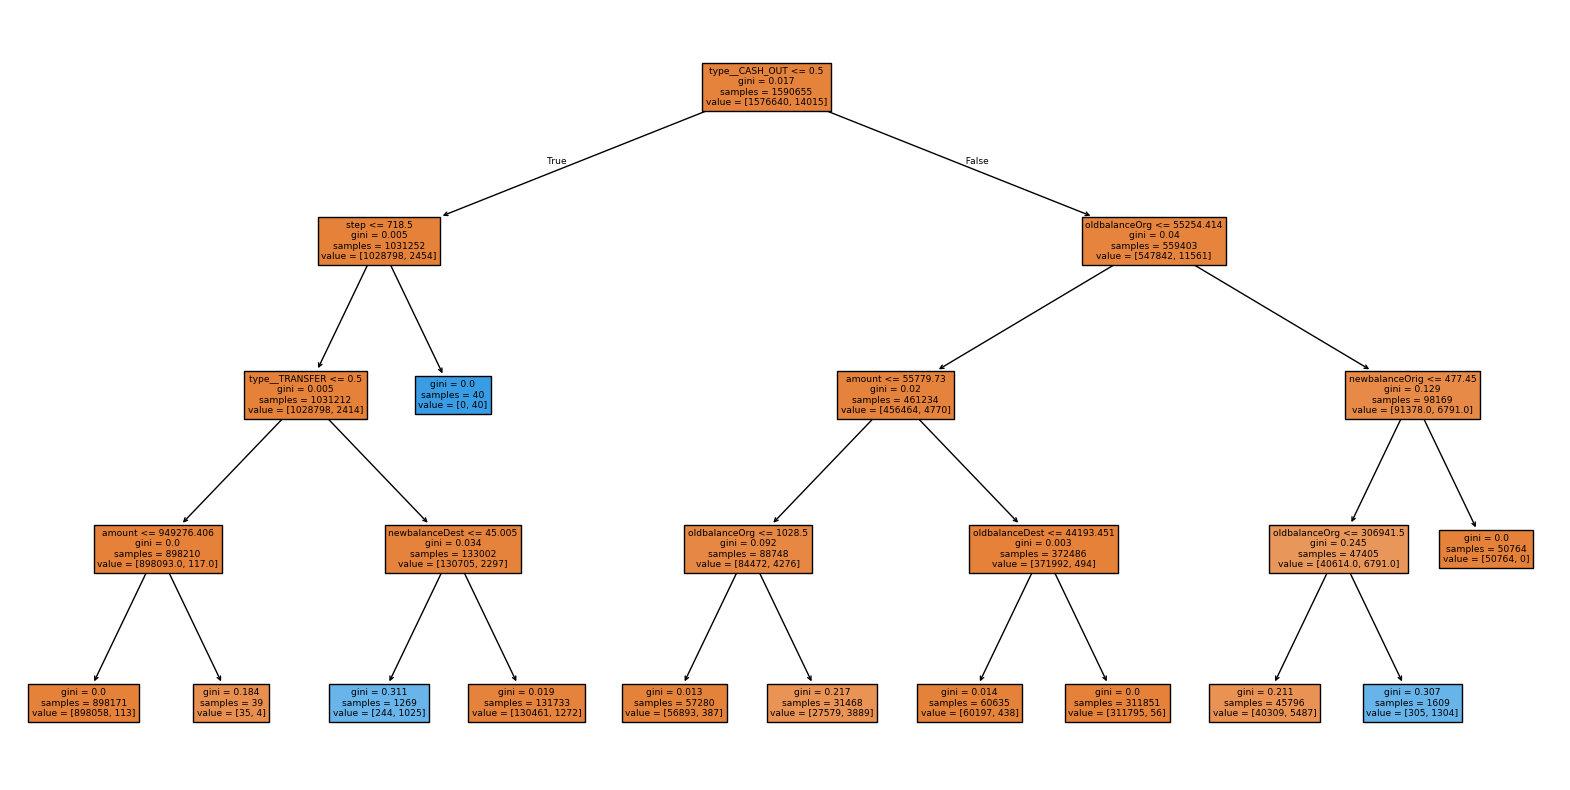

In [60]:
plt.figure(figsize=(20,10))
plot_tree(gsm_model, feature_names=X_test.columns, filled=True)
plt.show()

### Permutation Feature Importance

In [63]:
def scoring(model, X_test, y_test):
    pred = model.predict(X_test)
    return accuracy_score(y_test, pred)

In [64]:
pfi_scores = permutation_importance(model, X_test.iloc[:1000], y_test[:1000], scoring=scoring)

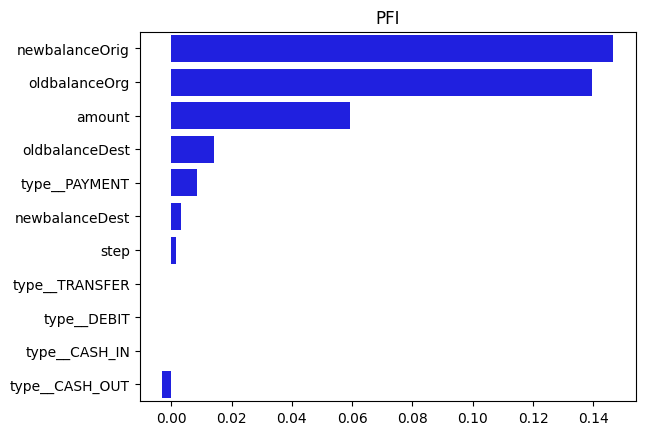

In [65]:
idx = pfi_scores.importances_mean.argsort()[-1::-1]
sns.barplot(x=pfi_scores.importances_mean[idx], y=X_test.columns.values[idx], orient="h", color="blue")
plt.title("PFI")
plt.show()

### Global Scope SHAP

In [115]:
shap_explainer = shap.TreeExplainer(model)
shap_explaination = shap_explainer(X_test.sample(10000))

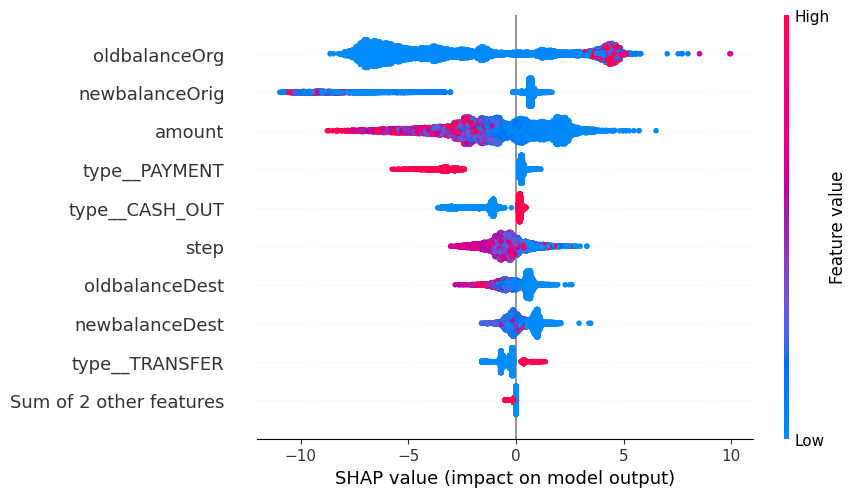

In [118]:
shap.plots.beeswarm(shap_explaination)

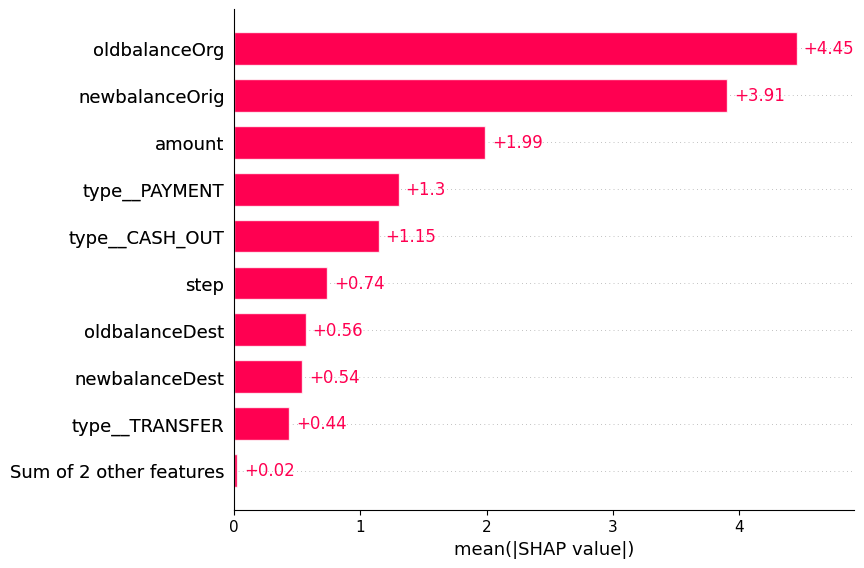

In [121]:
shap.plots.bar(shap_explaination)

### Local SHAP Interpretations

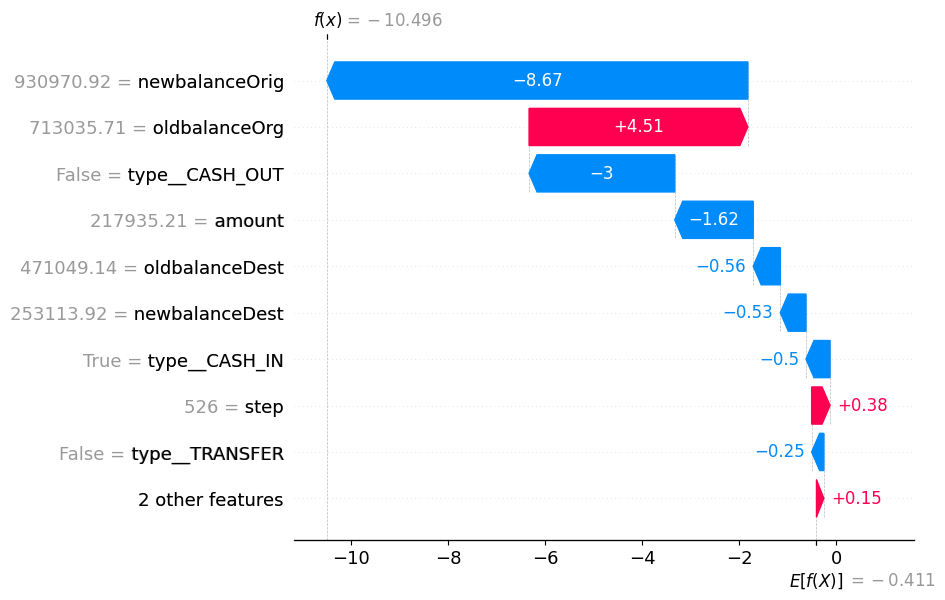

In [127]:
shap.plots.waterfall(shap_explaination[0])

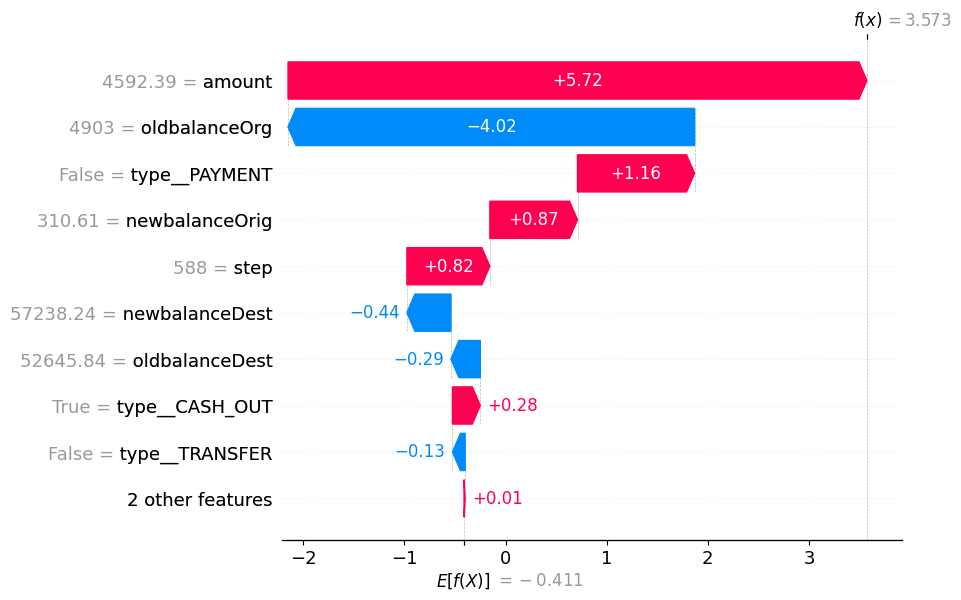

In [143]:
shap.plots.waterfall(shap_explaination[8])

## Disscussion

From the perspective of the fraud detection problem, our model shows strong performance, achieving a fraud recall score of 1, which means it catches all fraudulent transactions. However, this came with a low precision for the fraud class. Still, this is negligible due to the class imbalance. In reality, 99% of normal transactions are classified correctly, while only 1% are falsely flagged as fraud, which is still acceptable and comparable to state-of-the-art models, as it can mitigate fraud at a high rate.

For interpretation, we used model-agnostic methods. We used GSM for a high-level understanding of our model, PFI and SHAP mean absolute value for feature importance, SHAP Global Explanation for feature contribution and importance, and Local SHAP for explaining 2 examples locally.

The GSM shows that most fraud happens when the victim has a high balance and initiates a cash-out transaction, or when making a transfer to someone who has a low balance.
The PFI shows that the most important features are related to origin balance before and after, and amount.
The SHAP global values plot adds to the PFI findings by showing that when the old origin balance is high, it pushes the prediction toward fraud, and the reverse also holds. Similarly, when the amount is high, it pushes the prediction toward normal, and vice versa.
The SHAP mean values confirm the PFI output.

I examined a normal example with SHAP local interpretation, and the finding was that the model pushed the prediction toward normal based on the new origin balance, not being a cash-out transaction, and the amount.
When I examined a fraud example, the model pushed the prediction toward fraud, based on low amount, non-payment type, and small new origin balance.